In [380]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_distances
import math

In [203]:
mut = pd.read_csv('TCGA.HNSC.mutations.txt', sep='\t', header=0, index_col = [0])

In [222]:
clean_mut = mut[mut['Variant_Type'] == 'SNP']
#Sigtool = clean_mut[['Hugo_Symbol', 'Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']]
#Sigtool.to_csv('Sigtool.cvs')
clean_mut = clean_mut[['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2', 'CONTEXT']]


In [205]:

def get_middle(sequence):
    middle_index = len(sequence) // 2
    if len(sequence) % 2 == 0:
        return sequence[middle_index - 1: middle_index + 1]
    else:
        return sequence[middle_index]
# Apply the function to the 'context' column
clean_mut['middle'] = clean_mut['CONTEXT'].apply(get_middle)


In [206]:
def reverse_complement(sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in sequence[::-1])
# Apply the reverse complement function based on the condition
clean_mut['Complement'] = clean_mut['CONTEXT']
clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'] = clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'].apply(reverse_complement)

In [207]:
def find_middle_three(s):
    length = len(s)
    if length >= 3:
        return s[(length//2)-1:(length//2)+2]
    else:
        return s
clean_mut['Tri'] = clean_mut['Complement'].apply(find_middle_three)

In [208]:
clean_mut['Mut'] = (clean_mut['Tri'].str[0] +  "(" + clean_mut['Tri'].str[1] + ">" 
                     + clean_mut['Tumor_Seq_Allele2'].astype(str) + ')' + clean_mut['Tri'].str[2])


In [209]:
clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]

/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_1132/3941398218.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_1132/3941398218.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]


In [218]:
clean_mut

,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2,CONTEXT,middle,Complement,Tri,Mut
patient_id,,,,,,,,,
TCGA-4P-AA8J,10,22830863,G,A,CTCTCGCCCTC,G,GAGGGCGAGAG,GCG,G(C>A)G
TCGA-4P-AA8J,10,33495214,C,T,CATCTCTTCTT,C,CATCTCTTCTT,TCT,T(C>T)T
TCGA-4P-AA8J,10,6257188,C,T,GTGTTCAACGT,C,GTGTTCAACGT,TCA,T(C>T)A
TCGA-4P-AA8J,10,88260246,T,C,TAAAATACAGT,T,TAAAATACAGT,ATA,A(T>C)A
TCGA-4P-AA8J,11,1080567,T,C,TTCGATGGGAA,T,TTCGATGGGAA,ATG,A(T>C)G
...,...,...,...,...,...,...,...,...,...
TCGA-WA-A7H4,8,143381872,C,T,CCTCCCGCAGC,C,CCTCCCGCAGC,CCG,C(C>T)G
TCGA-WA-A7H4,8,59728263,G,A,TTCACGTCAAC,G,GTTGACGTGAA,ACG,A(C>A)G
TCGA-WA-A7H4,8,74235183,G,A,GTATCGGTTCC,G,GGAACCGATAC,CCG,C(C>A)G


In [211]:
mut_matrix = clean_mut[['Mut']]

In [212]:
mut_encoded_matrix = pd.pivot_table(mut_matrix, index='patient_id', columns='Mut', aggfunc='size', fill_value=0)

In [213]:
mut_encoded_matrix

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,7,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
TCGA-BA-4074,5,1,5,1,0,1,0,1,2,1,...,0,0,0,0,1,0,0,0,0,0
TCGA-BA-4075,3,5,3,3,0,0,0,1,1,5,...,0,1,0,0,0,1,2,0,0,2
TCGA-BA-4076,9,5,7,5,0,1,1,2,7,8,...,1,1,1,1,3,0,2,2,4,1
TCGA-BA-4077,1,1,4,0,0,0,0,0,1,1,...,0,1,0,1,0,1,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JT,4,2,2,1,1,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-UF-A7JV,0,0,1,1,0,0,0,0,2,1,...,1,1,0,1,0,0,0,0,0,0
TCGA-UP-A6WW,0,0,3,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [406]:

# Initialize lists to hold the mean sample cosine distances and average stabilities for each k
mean_cosine_distances = []
average_stabilities = []

# We'll test k values from 2 to 30
for k in range(1, 26):
    # Perform k-means clustering
    nmf = NMF(n_components=j, init='random', random_state=0, max_iter=10000)  # you can change n_components based on your needs
    df_nmf = nmf.fit_transform(mut_encoded_matrix)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_nmf)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Compute mean sample cosine distance
    cosine_dists = []
    for i in range(k):
        cluster_points = df_nmf[labels == i]
        cluster_center = centers[i]
        cosine_dists.extend(cosine_distances(cluster_points, cluster_center.reshape(1, -1)).flatten())
    mean_cosine_distances.append(np.mean(cosine_dists))

    # Compute average stability
    stabilities = []
    for _ in range(100):  # Perform bootstrapping 100 times
        # Create a bootstrap sample
        bootstrap_sample = resample(df_nmf)  #poisson or resample here
        # Perform k-means clustering on the bootstrap sample
        bootstrap_kmeans = KMeans(n_clusters=k, random_state=0).fit(bootstrap_sample)
        # Compute stability as the adjusted rand index between the bootstrap clustering and the original clustering
        stability = adjusted_rand_score(labels, bootstrap_kmeans.predict(df_nmf))
        stabilities.append(stability)
    average_stabilities.append(np.mean(stabilities))


/Users/panbochen/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/panbochen/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


KeyboardInterrupt: 

In [407]:
diff = [average_stabilities[i] - mean_cosine_distances[i] for i in range(len(average_stabilities))]
best_k = diff.index(max(diff)) 
best_k

0

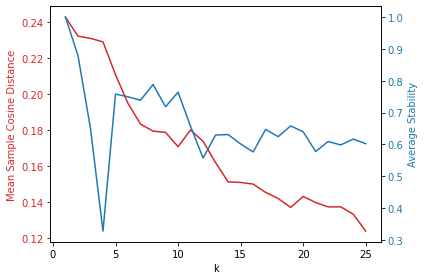

In [408]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Mean Sample Cosine Distance', color=color)
ax1.plot(range(1, 26), mean_cosine_distances, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Stability', color=color)
ax2.plot(range(1, 26), average_stabilities, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import numpy as np

# Initialize lists to hold the signature reproducibility and Frobenius reconstruction errors for each k
signature_reproducibilities = []
frobenius_errors = []

for k in range(1, 26):
    reproducibilities = []
    nmf = NMF(n_components=k, init='random', random_state=0, max_iter=10000)
    W = nmf.fit_transform(mut_encoded_matrix)
    H = nmf.components_

    for _ in range(100):  # Perform NMF 100 times to calculate signature reproducibility
        lambda_x = 1
        bootstrap_sample = np.random.poisson(mut_encoded_matrix * lambda_x)
        nmf_i = NMF(n_components=k, init='random', random_state=0, max_iter=10000)
        W_i = nmf_i.fit_transform(bootstrap_sample)
        H_i = nmf_i.components_
        # Calculate cosine similarity between the base components and the new components
        similarity = cosine_similarity(H, H_i)
        reproducibility = np.mean(similarity)
        reproducibilities.append(reproducibility)

    # Calculate Frobenius reconstruction error
    reconstruction = np.dot(W, H)
    frobenius_error = norm(mut_encoded_matrix - reconstruction, 'fro')
    frobenius_errors.append(frobenius_error)
    signature_reproducibilities.append(np.mean(reproducibilities))

# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Signature Reproducibility', color=color)
ax1.plot(range(1, 26), signature_reproducibilities, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(1, 26), frobenius_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()



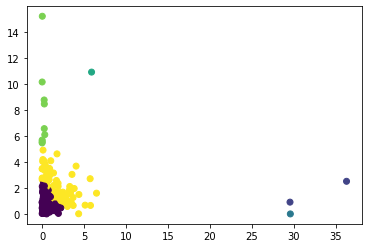

In [436]:

kmeans = KMeans(n_clusters= 6, random_state=1, max_iter=10000)
kmeans.fit(mut_encoded_matrix)
y_pred = kmeans.predict(mut_encoded_matrix)
SSE.append(kmeans.inertia_)
y_preds.append(y_pred)

labels = kmeans.labels_

# plot the data points, colored by their assigned cluster
plt.scatter(df_nmf[:, 0], df_nmf[:, 1], c=labels, cmap='viridis')

plt.show()

In [387]:
mean_cosine_distances

[0.23235957799120105,
 0.23113836238435817,
 0.22917186018510102,
 0.21089191867726192,
 0.19485630555848568,
 0.18335262405486102,
 0.17944248749915392,
 0.17876572658896323,
 0.17082773254219466,
 0.18008622442047212,
 0.17374635275155034,
 0.16189623486012386,
 0.15118907432705564,
 0.15085441388153306,
 0.1499402195242404,
 0.1453386431512344,
 0.1419200856717386,
 0.13693291964059348,
 0.14303702699519413,
 0.13965107345702502,
 0.137213404935085,
 0.13728178307047492,
 0.13319149464513594,
 0.12374032154345982,
 0.13186347683735228,
 0.12972199897568618,
 0.12074859120589816,
 0.11935628246999822]

In [249]:
for i in range(10):
    lambda_x = 1
    pd = np.random.poisson(mut_encoded_matrix * lambda_x)

In [87]:
column_sums = np.sum(coefficient, axis=0)

# Index of the original feature most influenced by the hidden features
most_influenced_feature = np.argmax(column_sums)
most_influenced_feature

72

In [88]:
mut_matrix.iloc[72]

Mut    G(T>C)C
Name: (TCGA-4P-AA8J, KDM1A), dtype: object

In [ ]:
df_resampled

In [97]:
from SigProfilerExtractor import sigpro as sig
path_to_example_table = sig.importdata("matrix")
data = path_to_example_table 

ModuleNotFoundError: No module named 'SigProfilerExtractor'